# <Font color = 'indianred'>**Specify Project Folder**

In [1]:
# add lines for autoreload
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data')
    data_folder = Path('/content')

    !pip install pytorch-lightning -U -qq
    !pip install torchinfo -U -qq

else:
    base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor')
    data_folder = Path('/home/harpreet/data')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 14.7 MB/s eta 0:00:00


In [3]:
custom_function_folder = base_folder/'/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files'
sys.path.append(str(custom_function_folder))
model_folder = base_folder/'data/models/dl_fall_2023/fmnist'
model_folder.mkdir(parents=True, exist_ok=True)

# <Font color = 'indianred'>**Import Libraries**

In [4]:
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
import torchmetrics

import torch.nn.functional as F
from data_loaders_fmnist import get_loaders
from model_two_layer import TwoLayerMLP
from shared_utils import check_loader, check_transforms, check_label_dist, show_confusion_matrix, compute_accuracy, plot_losses_acc
from datetime import datetime


# <Font color = 'indianred'>**Get dataloaders**

In [5]:
# Define preprocessing transformations for training and testing datasets
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.2857,), (0.3528)),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.2857,), (0.3528)),
        ]
    ),
}

In [6]:
####NEW######
torch.manual_seed(123)
train_loader, val_loader, test_loader = get_loaders(data_folder=data_folder ,
                                                    train_transform=data_transforms['train'],
                                                    test_transform=data_transforms['test'],
                                                    fraction_train=0.8,
                                                    seed=42,
                                                    batch_size = 256,
                                                    small_subset= False,
                                                   )

100%|██████████| 26421880/26421880 [00:02<00:00, 12658426.45it/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203596.27it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3763319.40it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5931944.23it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [7]:
check_loader(train_loader)

 Batch Number: 1 | Batch size: 256 | x shape: torch.Size([256, 1, 28, 28]) | y shape: torch.Size([256])
 Batch Number: 2 | Batch size: 256 | x shape: torch.Size([256, 1, 28, 28]) | y shape: torch.Size([256])
 Batch Number: 3 | Batch size: 256 | x shape: torch.Size([256, 1, 28, 28]) | y shape: torch.Size([256])

Labels from current batch 
 tensor([7, 6, 7, 3, 7, 3, 5, 3, 8, 1, 0, 3, 3, 3, 9, 1, 9, 1, 2, 4, 4, 9, 9, 8,
        1, 0, 4, 7, 2, 3, 7, 3, 7, 8, 9, 4, 7, 4, 0, 3, 4, 0, 4, 2, 4, 0, 2, 0,
        1, 3, 1, 9, 4, 4, 0, 7, 0, 6, 5, 4, 3, 8, 5, 6, 1, 8, 1, 5, 4, 7, 5, 5,
        1, 7, 3, 6, 7, 7, 6, 9, 1, 5, 0, 6, 8, 3, 2, 1, 5, 7, 8, 8, 7, 8, 0, 1,
        4, 4, 7, 4, 3, 3, 7, 3, 9, 5, 8, 3, 7, 0, 0, 8, 4, 6, 4, 3, 7, 8, 2, 7,
        6, 8, 4, 0, 7, 1, 9, 5, 3, 6, 9, 2, 2, 8, 7, 1, 4, 8, 0, 9, 0, 1, 9, 6,
        7, 5, 8, 3, 4, 1, 5, 8, 5, 9, 6, 5, 5, 1, 1, 1, 7, 2, 2, 2, 9, 6, 7, 5,
        1, 3, 5, 3, 0, 4, 6, 3, 8, 5, 4, 2, 1, 3, 3, 9, 2, 8, 0, 8, 7, 5, 1, 1,
        7, 4, 7, 8,

In [8]:
check_transforms(train_loader)

shape of inputs is :torch.Size([256, 1, 28, 28])

max input value  :2.0246598720550537

min input value  :-0.8098071813583374

mean input value  :0.015107324346899986

std input value  :1.008495569229126

shape of targets is :torch.Size([256])

inputs  :tensor([[-0.8098, -0.8098, -0.8098, -0.8098,  0.0127],
        [-0.8098, -0.8098, -0.8098, -0.8098,  0.1684],
        [-0.8098, -0.8098, -0.8098, -0.8098,  0.2128],
        [-0.8098, -0.8098, -0.8098, -0.8098,  0.1572],
        [-0.8098, -0.8098, -0.8098, -0.8098,  0.1128]])


In [9]:
check_label_dist(train_loader)


 Label distribution:


[(0, 4732),
 (1, 4752),
 (2, 4825),
 (3, 4852),
 (4, 4807),
 (5, 4797),
 (6, 4788),
 (7, 4866),
 (8, 4805),
 (9, 4776)]

In [10]:
class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = model
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        inputs, labels = batch
        output = self(inputs)
        loss = F.cross_entropy(output, labels)
        predicted_labels = torch.argmax(output, dim=1)
        return loss, labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)

        # Log at every 50 steps
        if batch_idx % 50 == 0:
            self.log("train_loss_step", loss, on_step=True, on_epoch=False)

        self.train_acc(predicted_labels, labels)

        # Log for the epoch average
        self.log("train_loss_epoch", loss, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_acc, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)
        self.log("val_loss", loss, on_epoch=True, on_step=False)
        self.val_acc(predicted_labels, labels)
        self.log("val_acc", self.val_acc, prog_bar=True, on_epoch=True, on_step=False)

    def on_train_epoch_end(self):
        metrics = self.trainer.callback_metrics

        # Using 'train_loss_epoch' to get the average loss for the epoch
        print(f"Train_Loss: {metrics['train_loss_epoch']:.2f}, Train_Acc: {metrics['train_acc']:.2f}")

    def on_validation_epoch_end(self):
        metrics = self.trainer.callback_metrics
        epoch_num = self.current_epoch
        print(f"Epoch {epoch_num + 1}: Val_Loss: {metrics['val_loss']:.2f}, Val_Acc: {metrics['val_acc']:.2f}" ,end=" | ", flush=True)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

    def test_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, labels)
        self.log("test_acc", self.test_acc)

# <Font color = 'indianred'>**Train Model**

In [11]:
# Define the model architecture and training parameters
num_features = 1*28*28
hidden_dim1 = 200
hidden_dim2 = 100
num_classes = 10
epochs = 10
learning_rate = 0.03


# Set a random seed for reproducibility
torch.manual_seed(42)

# Create the neural network model
model = TwoLayerMLP(num_features, hidden_dim1, hidden_dim2, num_classes)

lightning_model = LightningModel(model=model, learning_rate=learning_rate)


# Determine the computing device (CPU or GPU) to use
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

summary(model, (1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
TwoLayerMLP                              [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 200]                  157,000
│    └─ReLU: 2-3                         [1, 200]                  --
│    └─Linear: 2-4                       [1, 100]                  20,100
│    └─ReLU: 2-5                         [1, 100]                  --
│    └─Linear: 2-6                       [1, 10]                   1,010
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.71
Estimated Total Size (MB): 0.72

In [12]:
trainer = pl.Trainer(
        max_epochs=10,
        accelerator="auto",  # set to "auto" or "gpu" to use GPUs if available
        devices="auto",  # Uses all available GPUs if applicable
        deterministic=True,
        logger=CSVLogger(save_dir=model_folder/'logs', name="two_layer"),
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(
        model=lightning_model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader,
    )

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | TwoLayerMLP        | 178 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
178 K     Trainable params
0         Non-trainable params
178 K     Total params
0.712     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.31, Val_Acc: 0.15 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.65, Val_Acc: 0.77 | Train_Loss: 1.05, Train_Acc: 0.68


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.53, Val_Acc: 0.81 | Train_Loss: 0.58, Train_Acc: 0.79


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.48, Val_Acc: 0.83 | Train_Loss: 0.50, Train_Acc: 0.82


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.46, Val_Acc: 0.84 | Train_Loss: 0.46, Train_Acc: 0.84


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.44, Val_Acc: 0.85 | Train_Loss: 0.44, Train_Acc: 0.84


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.43, Val_Acc: 0.85 | Train_Loss: 0.42, Train_Acc: 0.85


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 0.42, Val_Acc: 0.85 | Train_Loss: 0.40, Train_Acc: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 0.41, Val_Acc: 0.85 | Train_Loss: 0.39, Train_Acc: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.39, Val_Acc: 0.86 | Train_Loss: 0.38, Train_Acc: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 0.39, Val_Acc: 0.86 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Train_Loss: 0.37, Train_Acc: 0.87


# <Font color = 'indianred'>**Evaluation**

In [ ]:
train_acc = trainer.test(dataloaders=train_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/data/models/dl_fall_2023/fmnist/logs/two_layer/version_0/checkpoints/epoch=9-step=1880.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/data/models/dl_fall_2023/fmnist/logs/two_layer/version_0/checkpoints/epoch=9-step=1880.ckp

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8689374923706055     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
train_acc[0]

{'test_acc': 0.8689374923706055}

In [ ]:
train_acc = trainer.test(dataloaders=train_loader)[0]["test_acc"]
val_acc = trainer.test(dataloaders=val_loader)[0]["test_acc"]
test_acc = trainer.test(dataloaders=test_loader)[0]["test_acc"]


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/data/models/dl_fall_2023/fmnist/logs/two_layer/version_0/checkpoints/epoch=9-step=1880.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/data/models/dl_fall_2023/fmnist/logs/two_layer/version_0/checkpoints/epoch=9-step=1880.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8689374923706055     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/data/models/dl_fall_2023/fmnist/logs/two_layer/version_0/checkpoints/epoch=9-step=1880.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/data/models/dl_fall_2023/fmnist/logs/two_layer/version_0/checkpoints/epoch=9-step=1880.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8604999780654907     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/data/models/dl_fall_2023/fmnist/logs/two_layer/version_0/checkpoints/epoch=9-step=1880.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/data/models/dl_fall_2023/fmnist/logs/two_layer/version_0/checkpoints/epoch=9-step=1880.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8492000102996826     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
print(
    f"Train Acc {train_acc*100:.2f}%"
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)

Train Acc 86.89% | Val Acc 86.05% | Test Acc 84.92%


# <Font color = 'indianred'>**Plot Losses**

In [ ]:
file = f"{trainer.logger.log_dir}/metrics.csv"

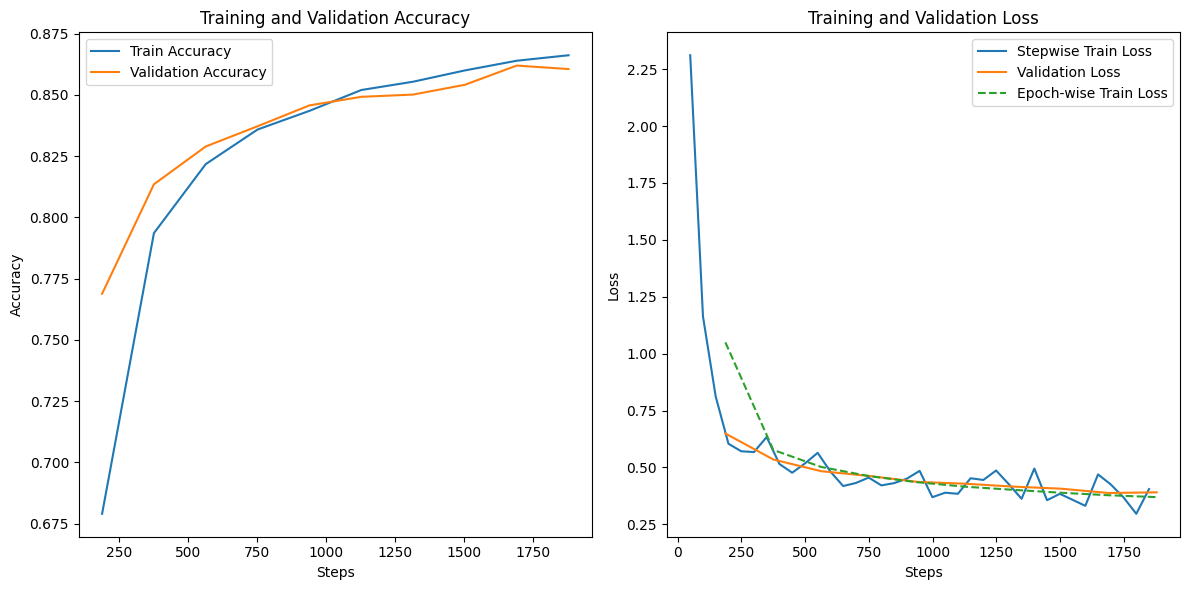

In [ ]:
plot_losses_acc(file)